## DS Challenge
Accelerometer data from 22 people walking.  Explore and exploit the data for subject identification.

See README.md for more information

### Preprocessing & Feature Extraction
**Please see the `accel_magnitude_training.ipynb` notebook for more information about preprocessing and feature extraction**

For simplicity, we will start by looking only at acceleration magnitude.  This has the benefit of being **rotation-invariant**.  If the phone/sensor is oriented differently in their pocket (relative to gravity), all these features will remain the same (as long as the sensitivity is consistent in each x,y,z).

Using the individual x,y,z vectors might provide extra discrimination value, but would require rotating the vectors in the sample to a common reference to accommodate variations in sensor orientation.  One way might be to get the average vector of the sample, and find the rotation matrix to orient the average vector to -z.  Then apply that rotation to all vectors in the sample.  Then we either need to find a way to orient around the z-axis, or transform them to features that are invariant to that rotation.  One idea I have for that calculating xy-angle shift and z-angle shift between successive vectors.  

In this notebook we'll start with just analyzing magnitude.

### Classification Approach

Observations:

* Limited data set size
* The data for each subject is modal

Therefore we use a K-Nearest-Neighbors algorithm, which has the benefit of not trying to reduce each subject to a single, average "profile".  As long as their motion matches one of the modes we observed during training, we have a chance to classify it correctly.


In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import seaborn as sns
import json
from accel_utils import AccelUtils

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
# Keep all params in a yaml file for
params = AccelUtils.read_params_file('params.json')
num_subj = params['num_subj']
max_resample_pts = params['max_resample_pts']
min_timesteps_per_sample = int(params['max_resample_pts'] * params['filt_min_timesteps_per_sample_ratio'])

Params:
{
  "data_dir": "./user_data",
  "filt_avg_power": 2.0,
  "filt_dc_ratio": 0.7,
  "filt_power_ratio": 0.5,
  "filt_min_samples_per_subj": 8,
  "max_dt": 0.035,
  "filt_min_timesteps_per_sample_ratio": 0.9,
  "resample_dt": 0.03,
  "window_size_sec": 3.3,
  "num_subj": 22,
  "max_resample_pts": 105,
  "min_timesteps_per_sample": 94
}
Number of files/subjects: 22
Each sample will be 105 time steps


### Read all .csv, extract valid time windows


In [9]:
per_user_all_data = AccelUtils.read_all_user_data(params['data_dir'], num_subj)
valid_windows_by_user = {}
for i in range(num_subj):
    df = per_user_all_data[i]
    valid_windows_by_user[i] = AccelUtils.extract_valid_time_windows_for_subj(
        df, params['window_size_sec'], min_timesteps_per_sample)

### Sample Window extraction (subj 3)
Top is the original signal, bottom is all the time slices that will be used for training & testing
![](example_valid_windows_subj_11.png)

### Display how many samples we have per subject
We will have to remove anything that has less than 10 samples

In [11]:
min_samples = params['filt_min_samples_per_subj']
counts = [len(valid_windows_by_user[i]) for i in range(num_subj)]
use_subjs = [i for i in range(num_subj) if counts[i] >= min_samples]
print(f'Keeping {len(use_subjs)} subjects {use_subjs}')

Keeping 16 subjects [0, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 16, 17, 19, 21]


## Compute features for each valid window, split into a train & test set

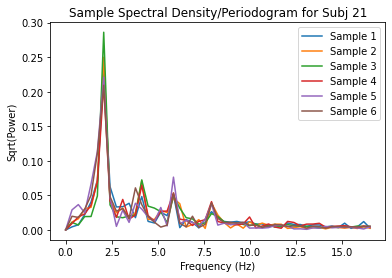

In [138]:
all_rows = []
fig,ax = plt.subplots()
for i_subj in use_subjs:
    for i_win, window in enumerate(valid_windows_by_user[i_subj]):
        fs, pow_norm = AccelUtils.compute_periodogram(
            window,
            params['resample_dt'],
            max_resample_pts)
        
        all_rows.append(pow_norm.tolist() + [i_subj])
        
        if i_subj==0 and i_win < 6:
            ax.plot(fs, pow_norm)
            
ax.set_xlabel('Frequency (Hz)')
ax.set_ylabel('Sqrt(Power)')
ax.set_title(f'Sample Spectral Density/Periodogram for Subj {i_subj}')
ax.legend([f'Sample {i+1}' for i in range(6)])
col_headers = [f'f{freq:.1f}' for freq in fs] + ['label']

That looks pretty consistent...

### Some standard data cleaning
Make sure labels are integers, remove any NA values

In [165]:
full_df = pd.DataFrame.from_records(all_rows, columns=col_headers)
full_df.dropna(axis=0, inplace=True)
full_df['label'] = full_df['label'].astype('int32')
print('Total dataset size:', full_df.shape)
full_df.head(4)

Total dataset size: (929, 50)


,f0.0,f0.3,f0.7,f1.0,f1.4,f1.7,f2.1,f2.4,f2.7,f3.1,...,f13.7,f14.1,f14.4,f14.8,f15.1,f15.5,f15.8,f16.2,f16.5,label
0,1.628033e-16,0.004394,0.007440,0.022217,0.040325,0.071902,0.226240,0.062634,0.033245,0.033543,...,0.007162,0.004483,0.005629,0.003382,0.009765,0.002256,0.004388,0.012069,0.002588,0
1,4.969320e-17,0.011395,0.016113,0.030438,0.032716,0.071385,0.249845,0.042405,0.024808,0.031530,...,0.003668,0.001544,0.003891,0.003609,0.002543,0.003837,0.002057,0.004640,0.002415,0
2,1.120445e-16,0.010787,0.007187,0.019298,0.019423,0.049077,0.285968,0.036207,0.019001,0.017645,...,0.002688,0.004336,0.004251,0.003496,0.004760,0.004096,0.005609,0.004977,0.004873,0
3,1.187767e-16,0.009343,0.018827,0.023172,0.035797,0.069440,0.210527,0.041955,0.018123,0.044103,...,0.009589,0.003908,0.005015,0.005541,0.006139,0.004533,0.003050,0.005733,0.003797,0


------

## Split the Data into Test and Train Sets
We use sklearn's StratifiedKFold to make sure we get proportional representation of all classes in both test and train sets

In [140]:
# First arg to the split() method doesn't actually matter
num_splits = 5
if params['random_splits']:
    skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=3141592653)
else:
    skf = StratifiedKFold(n_splits=num_splits)
    

def get_skf_split(df, skf, split_idx): 
    all_splits = skf.split([0]*df.shape[0], df['label'].values)
    train_indices, test_indices = list(all_splits)[split_idx]

    X_train = df.iloc[train_indices, :-1]
    y_train = df.iloc[train_indices, -1]
    X_test = df.iloc[test_indices, :-1]
    y_test = df.iloc[test_indices, -1]
    return X_train, y_train, X_test, y_test

for i in range(num_splits):
    xt,yt,xs,ys = get_skf_split(df, skf, i)
    print(f'Training shapes: X ~ {xt.shape}, y ~ {yt.shape}')
    print(f'Testing shapes:  X ~ {xs.shape}, y ~ {ys.shape}')

Training shapes: X ~ (743, 49), y ~ (743,)
Testing shapes:  X ~ (186, 49), y ~ (186,)
Training shapes: X ~ (743, 49), y ~ (743,)
Testing shapes:  X ~ (186, 49), y ~ (186,)
Training shapes: X ~ (743, 49), y ~ (743,)
Testing shapes:  X ~ (186, 49), y ~ (186,)
Training shapes: X ~ (743, 49), y ~ (743,)
Testing shapes:  X ~ (186, 49), y ~ (186,)
Training shapes: X ~ (744, 49), y ~ (744,)
Testing shapes:  X ~ (185, 49), y ~ (185,)


### Normalize Input Features
We use sklearn's standard scaler 

In [141]:
# We would want this if we had standard features, but these are periodograms
"""
scaler = sklearn.preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# We can pickle the scaler to disk to save for later
import pickle
with open('xdata_scaler.pickle', 'wb') as f:
    pickle.dump(scaler, f)
"""
X_train_scaled = X_train
X_test_scaled = X_test

### Create Classifier and Train
"Training" is a funny word to use with KNN -- you just add all the training samples to a list...

100 (100,)
Same min: 0.16300965133616577
Diff min: 6.993712108575504
Same max: 0.22045081830837293
Diff max: 7.029316456987157
Same sum: 0.3834604696445387
Diff sum: 14.023028565562662
Same geom: 0.0937139910732702
Diff geom: 3.5057345416073895


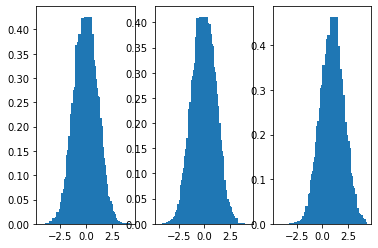

In [155]:
def kl_divergence(a, b):
    valid = a != 0
    return np.sum(a[valid] * np.log(a[valid] / (b[valid] + 1e-8)))

# Implement a KL-divergence-based distance (symmetric)
def distance_kldiv(y1, y2, pool_func):
    
    kl1 =  kl_divergence(y1, y2) + 1e-8
    kl2 =  kl_divergence(y2, y1) + 1e-8
    if pool_func == 'min':
        return min(kl1, kl2)
    elif pool_func == 'max':
        return max(kl1, kl2)
    elif pool_func == 'sum':
        return kl1 + kl2
    elif pool_func == 'geom':
        return 1.0 / (1.0/kl1 + 1.0/kl2)
    
    
bins=100
w=4.0
t1 = np.random.normal(size=(10000,))
t2 = np.random.normal(size=(10000,))
t3 = np.random.normal(loc=1.0, size=(10000,))
t1_hist, edges = np.histogram(t1, bins=bins, range=(-w, w), density=True, )
t2_hist, edges = np.histogram(t2, bins=bins, range=(-w, w), density=True)
t3_hist, edges = np.histogram(t3, bins=bins, range=(-w, w), density=True)

fig, axs = plt.subplots(1, 3)
xrange = list(np.arange(-w, w, step=2*w/bins))
print(len(xrange), t1_hist.shape)
axs[0].bar(xrange, t1_hist)
axs[1].bar(xrange, t2_hist)
axs[2].bar(xrange, t3_hist)

for kltype in ['min', 'max', 'sum', 'geom']:
    print(f'Same {kltype}:', distance_kldiv(t1_hist, t2_hist, kltype))
    print(f'Diff {kltype}:', distance_kldiv(t1_hist, t3_hist, kltype))


In [163]:
def train_kfold(df, skf, metric='L2'):
    y_true_agg, y_pred_agg = [], []
    for i in range(num_splits):
        X_train_scaled, y_train, X_test_scaled, y_test = get_skf_split(df, skf, i)
        if metric in [None, 'L2']:
            # Regular L2 distance
            knn = KNeighborsClassifier(n_neighbors=1)
        else:
            # Try one of the 
            dist_func = lambda a,b: distance_kldiv(a, b, metric)
            knn = KNeighborsClassifier(n_neighbors=1, metric=dist_func)
        
        knn.fit(X_train_scaled, y_train)
        y_pred = knn.predict(X_test_scaled)
        y_true_agg.append(y_test)
        y_pred_agg.append(y_pred)
        
    acc = sklearn.metrics.accuracy_score(np.concatenate(y_true_agg), np.concatenate(y_pred_agg)) 
    print('Metric:', metric.ljust(4), f'Acc: {acc:4f}')
    
for kltype in ['L2', 'min', 'max', 'sum', 'geom']:
    train_kfold(df, skf, kltype)
    #print(kltype, sklearn.metrics.accuracy_score(y_test, y_pred))

Metric: L2   0.531755
Metric: min  0.524220
Metric: max  0.505920
Metric: sum  0.505920
Metric: geom 0.505920


In [145]:
X_train_scaled, y_train, X_test_scaled, y_test = get_skf_split(df, skf, 2)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print('L2', sklearn.metrics.accuracy_score(y_test, y_pred))
                           
for kltype in ['min', 'max', 'sum', 'geom']:
    dist_func = lambda a,b: distance_kldiv(a, b, kltype)
    knn = KNeighborsClassifier(n_neighbors=1, metric=dist_func)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    print(kltype, sklearn.metrics.accuracy_score(y_test, y_pred))

L2 0.5376344086021505
min 0.553763440860215
max 0.510752688172043
sum 0.532258064516129
geom 0.532258064516129


In [146]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_scaled, y_train)
y_pred = knn.predict(X_test_scaled)
print(sklearn.metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.55      0.86      0.67         7
           1       0.00      0.00      0.00         3
           3       0.67      0.57      0.62         7
           5       1.00      0.17      0.29         6
           6       0.00      0.00      0.00         4
           7       0.00      0.00      0.00         4
           8       0.30      0.43      0.35         7
           9       0.50      0.67      0.57         6
          10       0.40      0.67      0.50         9
          11       0.22      0.33      0.27         6
          12       0.29      0.22      0.25         9
          13       0.00      0.00      0.00         9
          14       0.62      1.00      0.77         5
          15       0.00      0.00      0.00         2
          16       0.69      0.71      0.70        28
          17       0.58      0.50      0.54        28
          19       0.74      0.90      0.81        29
          20       0.00    

/home/alan/projects/venv382/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Confusion Matrix


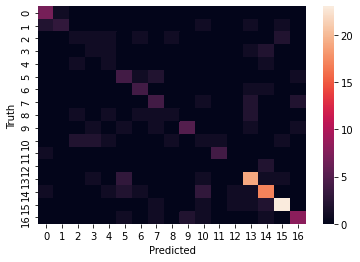

In [70]:
fig,ax = plt.subplots()
ax = sns.heatmap(sklearn.metrics.confusion_matrix(y_test, y_pred, labels=use_subjs), ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Truth')
print('Confusion Matrix')

fig.savefig('confusion_matrix.png')

Confusion Matrix isn't all that exciting...